## from previous notebook we got cropped arrays of image X and classes which is y
#### Directly loading them using np.load and processing forward

In [0]:
from google.colab import drive
drive.mount('/drive/')

In [0]:
import os 
os.chdir('/drive/My Drive/data/faces')

In [0]:
import numpy as np
import pandas as pd
import re
import cv2
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

#Misc for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
ls

cropped/    female/     gender/                              me.jpg
face_data/  female.jpg  haarcascade_frontalface_default.xml  x_cropped.npz
face_tf/    fer2013/    male/                                y_cropped.npz


In [5]:
#load X
X = np.load('x_cropped.npz')
X = X.f.arr_0
X.shape

(23704, 4096)

In [6]:
#load y
y = np.load('y_cropped.npz')
y = y.f.arr_0
y.shape

(23704,)

In [7]:
#view X
X

array([[121, 131, 135, ..., 122, 121, 117],
       [ 85,  52,  23, ..., 130, 141, 142],
       [  9,  10,  10, ...,  74,  50,  24],
       ...,
       [ 26,  26,  26, ...,  99,  88,  80],
       [  0,   0,   0, ...,  71,  50,  31],
       [  3,   1,   6, ...,  67,  56,  52]], dtype=uint8)

In [8]:
#view y
y

array([0, 0, 1, ..., 1, 0, 0])

In [0]:
#define image_size back
image_size = 64

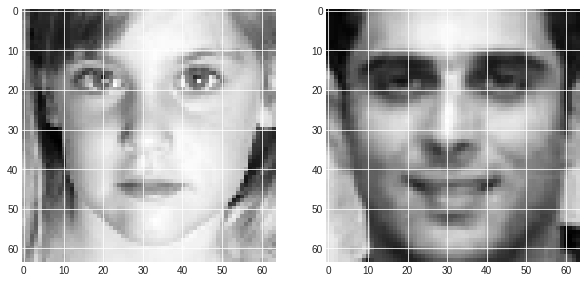

In [10]:
#recheck back
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
row = X[1]
row_1 = row.reshape((image_size,image_size))
plt.imshow(row_1,cmap='gray');
plt.subplot(1,2,2)
row = X[2]
row_1 = row.reshape((image_size,image_size))
plt.imshow(row_1,cmap='gray');

In [11]:
#train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.4)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((14222, 4096), (9482, 4096), (14222,), (9482,))

In [12]:
#reshaping to 64 64 as the input is 64 64 
x_train_reshape = x_train.reshape(-1,image_size,image_size,1)
x_test_reshape = x_test.reshape(-1,image_size,image_size,1)

x_train_reshape.shape,x_test_reshape.shape

((14222, 64, 64, 1), (9482, 64, 64, 1))

In [13]:
#downgrading the tensorflow (colab exclusive)
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
#Import libaries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

In [0]:
#define the CNN
def CNN():
  model = Sequential()
  model.add(Conv2D(filters=64,input_shape=(64,64,1),kernel_size=(3,3),activation='relu',strides=(1,1),padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',strides=(1,1),padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',strides=(1,1),padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',strides=(1,1),padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu',strides=(1,1),padding="same",kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(units=4096,activation='relu',kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(Dense(units=1000,activation='relu',kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(Dense(units=1000,activation='relu',kernel_regularizer=regularizers.l2(l=0.01)))
  model.add(Dense(units=2,activation='softmax'))
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
  return model

1. Add Sequential Model
2. Add Convolution Neural network (CNN) with **64 fliters** and input size as **image_size** kernel_size 3x3 with stride 1x1 and l2 regularizer paddind same results in padding the input such that the output has the same length as the original input with relu activation
3. No input, second layer don't need input, and same as the first layer
4. Batch Normalization, Normalize the previous scatter batch back to normal
5. MaxPool2D by **2x2**. Kinda like downlsampling
6. Dropping the half to next layer
7. New CNN with **256** filters followed by **step 4,5,6**
8. New CNN with **512** filters followed by step **4,5,6**
9. Flatten, which prepares a vector for the fully connected layers
10. Adding Fully connected layers with **4096,1000,1000**
11. One more with **2 units (female and male)** with softmax function
12. Compiling with adam optimizer and loss function as sparse categorical_crossentropy with accuracy as metric

In [16]:
#def and print summary
cnn = CNN()
print(cnn.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________

In [0]:
#saving for cross validation
cross_board = TensorBoard('cross_board')

In [19]:
#training with 10epochs and batch_size of 30
history = cnn.fit(x=x_train_reshape,y=y_train,batch_size=30,epochs=10,callbacks=[cross_board],validation_data=[x_test_reshape,y_test])

Train on 14222 samples, validate on 9482 samples
Epoch 1/10
14222/14222 [==============================] - 19s 1ms/sample - loss: 12.6385 - acc: 0.7083 - val_loss: 2.4959 - val_acc: 0.7176
Epoch 2/10
14222/14222 [==============================] - 14s 960us/sample - loss: 1.8349 - acc: 0.7958 - val_loss: 1.6274 - val_acc: 0.6073
Epoch 3/10
14222/14222 [==============================] - 14s 957us/sample - loss: 1.4137 - acc: 0.8140 - val_loss: 1.3854 - val_acc: 0.7640
Epoch 4/10
14222/14222 [==============================] - 14s 957us/sample - loss: 1.2707 - acc: 0.8143 - val_loss: 1.2355 - val_acc: 0.7970
Epoch 5/10
14222/14222 [==============================] - 14s 961us/sample - loss: 1.3277 - acc: 0.8137 - val_loss: 1.3398 - val_acc: 0.8004
Epoch 6/10
14222/14222 [==============================] - 14s 964us/sample - loss: 1.3151 - acc: 0.8240 - val_loss: 1.2851 - val_acc: 0.8526
Epoch 7/10
14222/14222 [==============================] - 14s 959us/sample - loss: 1.2281 - acc: 0.8268 - 

In [0]:
#saving the history of loss so we can plot
data_loss_nn = pd.DataFrame(history.history)

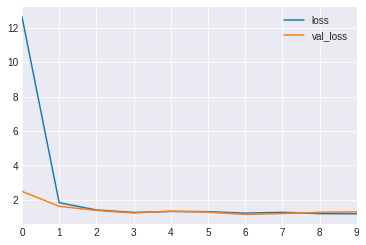

In [21]:
#plot
data_loss_nn[['loss','val_loss']].plot(kind='line');

**Seems Good enought, moderate fit, not overfit either underfit**

In [0]:
#load some test image for testing model
Image.open('./cropped/test/lady.jpeg')

In [0]:
in_img = cv2.imread("./cropped/test/lady.jpeg")

In [0]:
from google.colab.patches import cv2_imshow

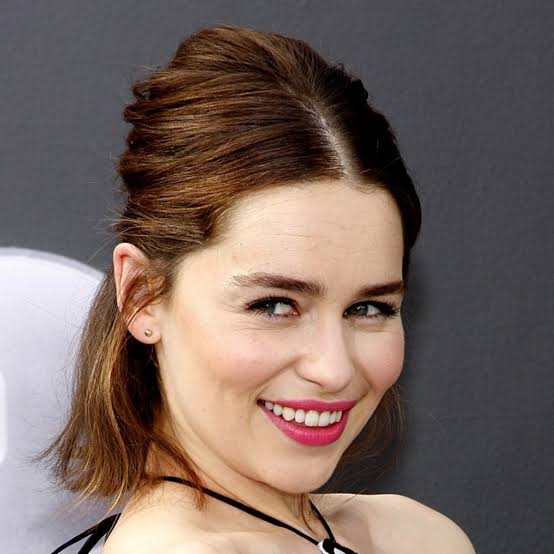

In [25]:
#display the loaded image
cv2_imshow(in_img)

In [0]:
#convert to gray scale
gray = cv2.cvtColor(in_img,cv2.COLOR_RGB2GRAY)

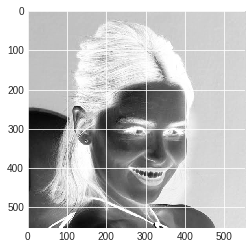

In [27]:
plt.imshow(gray);

**Here I use the Haarcascade Classifier for extracting the face from the test images which we are going to detect the gender. After getting the face from the test image we follow the same process we did convert it gray scale normalize (64 * 64), convert it to array and apply on the model for prediction**

In [0]:
#haarcascade for extracting the face
gender = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
gender = gender.detectMultiScale(gray, 1.3  , 3)

Gender: female


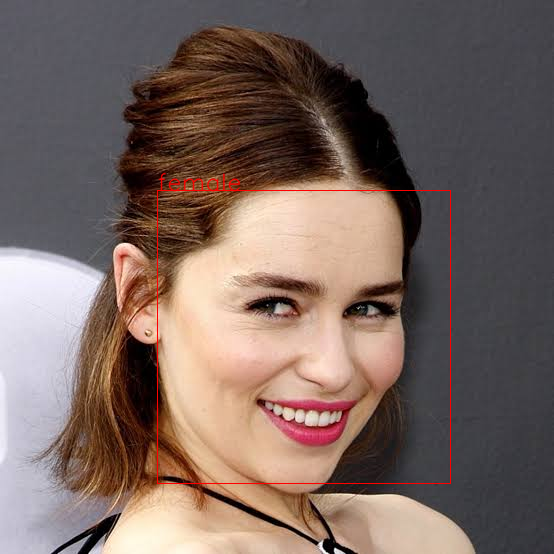

In [29]:
labels = ['female','male'] #labels instead of 0 and 1's
for (x, y, w, h) in gender:
        roi_gray = gray[y:y + h, x:x + w] #get image
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (64, 64)), -1), 0) #resize
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F) #normalize
        cv2.rectangle(in_img, (x, y), (x + w, y + h), (0, 0, 255), 1)
    
        yhat= cnn.predict(cropped_img) #predication
        #Adding text to the rectangle box
        cv2.putText(in_img, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1, cv2.LINE_AA)
        print("Gender: "+labels[int(np.argmax(yhat))])
#display
cv2_imshow(in_img)

**Detected has female, works good**

Let's Test some more

In [0]:
faces = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = faces.detectMultiScale(gray, 1.3  , 5)

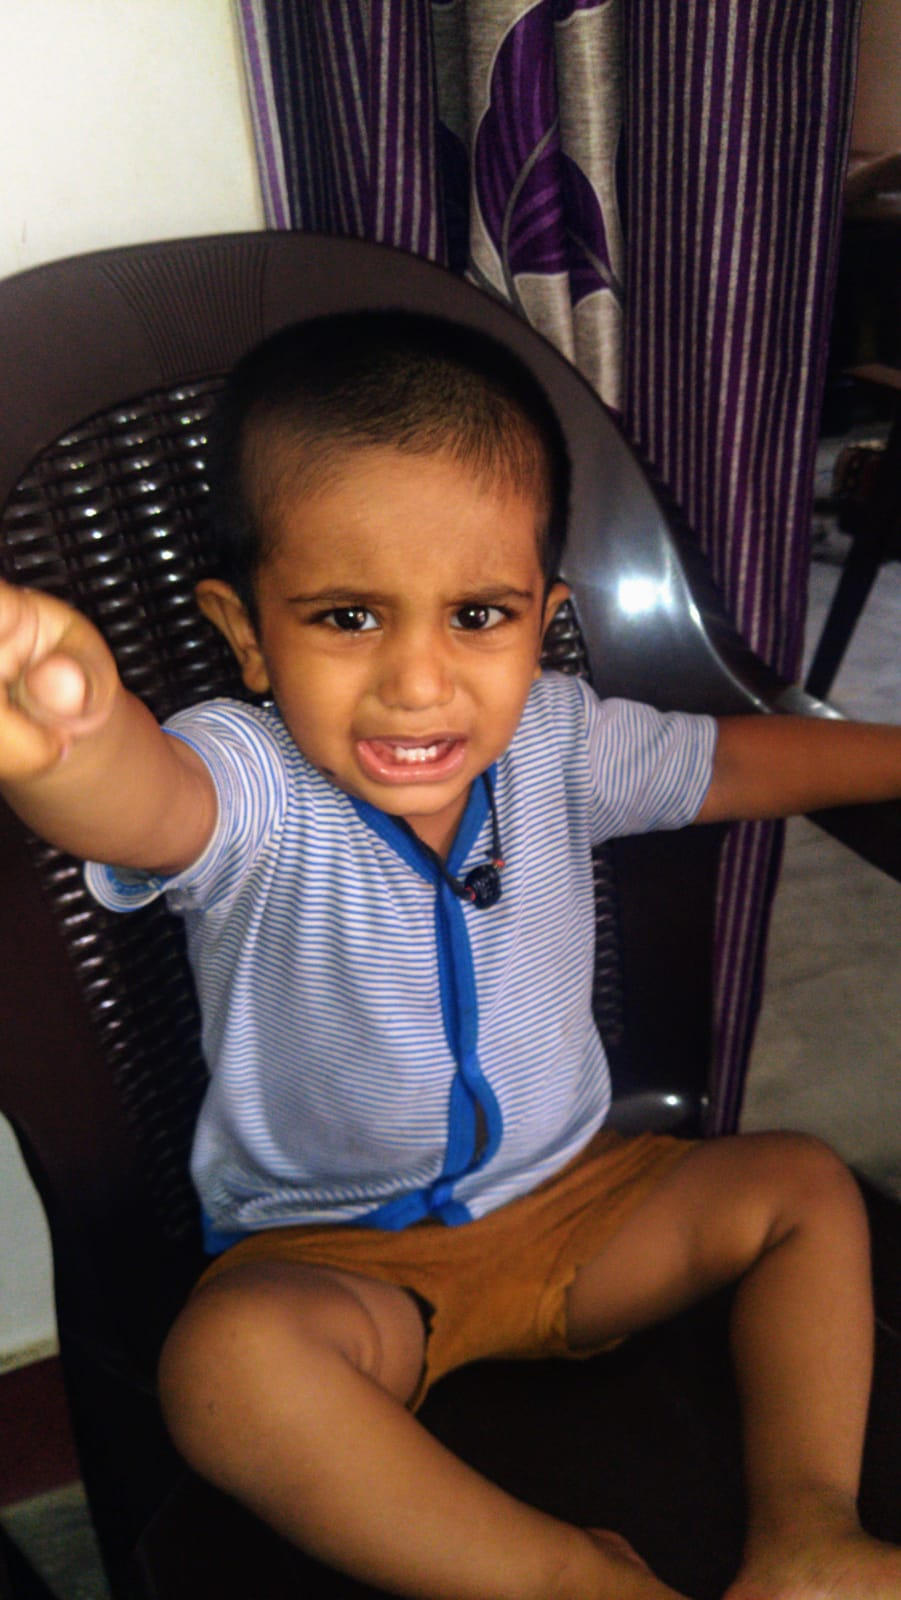

In [43]:
in_img = cv2.imread("./cropped/test/test_1.jpeg")
cv2_imshow(in_img)

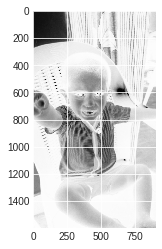

In [44]:
gray = cv2.cvtColor(in_img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray);

Gender: male


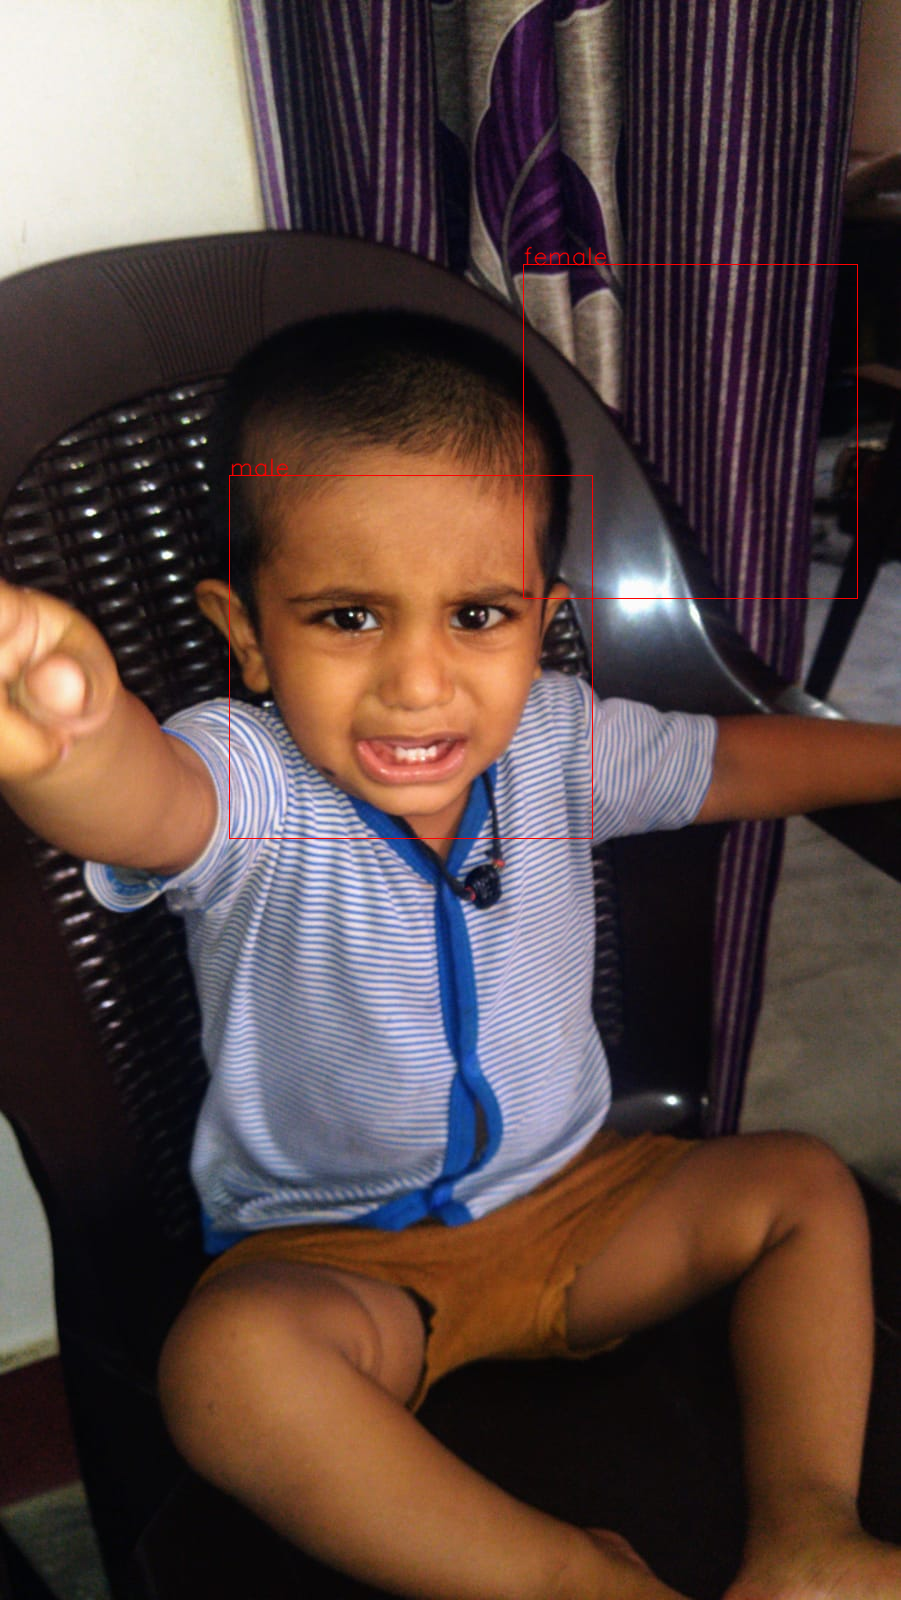

In [47]:
labels = ['female','male']
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (64, 64)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(in_img, (x, y), (x + w, y + h), (0, 0, 255), 1)
        yhat= cnn.predict(cropped_img)
        cv2.putText(in_img, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1, cv2.LINE_AA)
        print("Gender: "+labels[int(np.argmax(yhat))])

cv2_imshow(in_img)

Detects good!!!

**But Why I see Male and Female?**


Haarclassifer, I readjusted the parameters of classifer to get exact face of the baby, which it detected as female in the region, later on after tunning the classifer it got good **roi** and re detected as male again.Left out trace of female on pic back which is detected as female before where I didn't tune.

**Group Image**

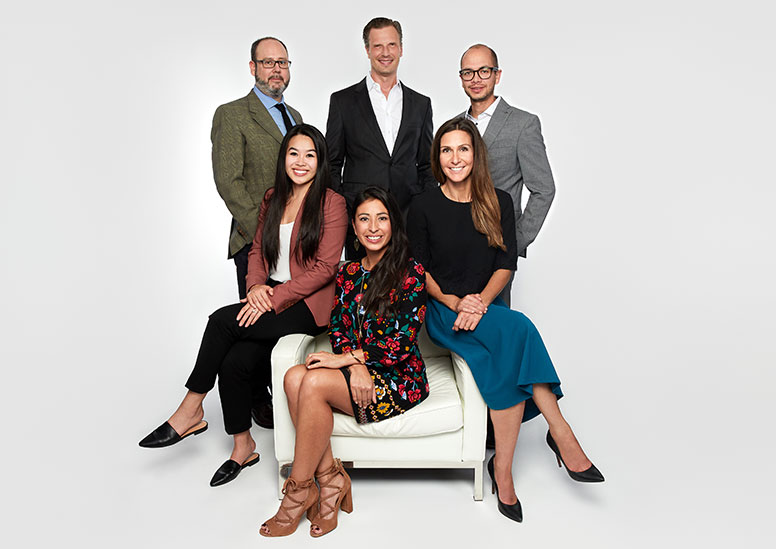

In [49]:
#Load group people image
in_img = cv2.imread("./cropped/test/group_test.jpg")
cv2_imshow(in_img)

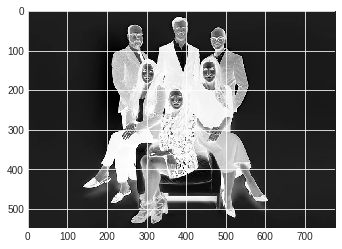

In [50]:
gray = cv2.cvtColor(in_img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray);

In [0]:
group = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
group = group.detectMultiScale(gray, 1.1  , 5)

Gender: male
Gender: male
Gender: male
Gender: female
Gender: female
Gender: female
Gender: male


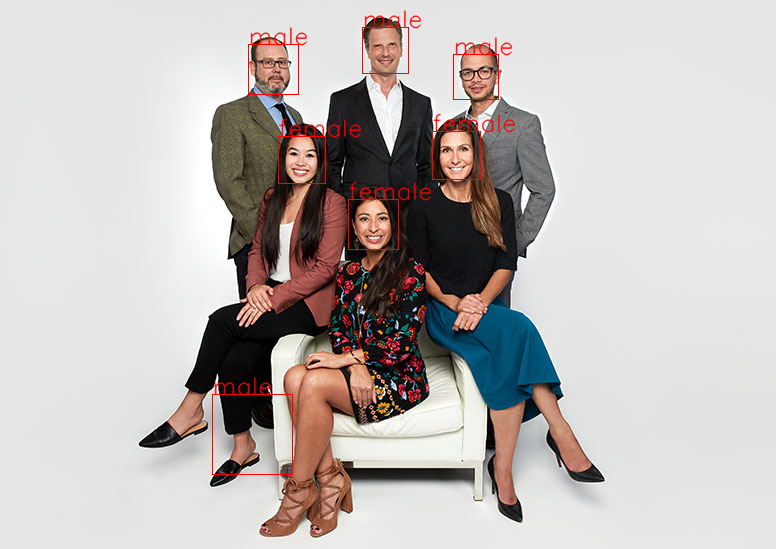

In [52]:
labels = ['female','male']
for (x, y, w, h) in group:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (64, 64)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(in_img, (x, y), (x + w, y + h), (0, 0, 255), 1)
        yhat= cnn.predict(cropped_img)
        cv2.putText(in_img, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1, cv2.LINE_AA)
        print("Gender: "+labels[int(np.argmax(yhat))])

cv2_imshow(in_img)

Detected Good Females as Females and Males as Males.

Oh!! I see the shoes of the female as male?, Tunning the haar classifer works, adjusting the neighbours, scaling factor and size. 

#### I don't own any copyrights on the images I used in this total series of notebooks.

#### source of data used for training: https://susanqq.github.io/UTKFace/
#### test source: google images
#### test image of baby is owned by friend of mine.